# Analysis of stop-and-frisk + camera locations in NYC

In [1]:
library(data.table)
library(ggplot2)
library(sf)
library(units)
library(geojsonsf)
library(lme4)

options(width=150)
theme_set(theme_bw(base_size=16))

Linking to GEOS 3.8.0, GDAL 3.0.4, PROJ 6.3.1; sf_use_s2() is TRUE

udunits database from /usr/share/xml/udunits/udunits2.xml

Loading required package: Matrix



## 0. Data preparation and inspection

#### SOURCES

* Stop-and-frisk (SQF) data from NYPD, 2019 and 2020. 
     https://www1.nyc.gov/site/nypd/stats/reports-analysis/stopfrisk.page

* Census data (demographics etc.) from the American Community Survey (ACS) 2014--2019, downloaded using
the `tidycensus` package:
    https://walker-data.com/tidycensus/articles/spatial-data.html

* Census tract shapefiles 2019 from US Census: 
    https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2019&layergroup=Census+Tracts trimmed to the New York state
shoreline: 
     http://gis.ny.gov/gisdata/inventories/details.cfm?DSID=927

* Camera locations, as provided by Amnesty's "Decode Surveillance NYC" project

#### PREPARED DATASETS

*  `tracts`:
    one row per census tract
    (excluding two entirely-aquatic census tracts, which have been removed).
    The shape of each tract is included.
    (All geo coordinates are in EPSG 2908, the State Plane Coordinate System for NY/LongIsland.)

* `census`:
    one row per census tract, excluding the two aquatic tracts

* `sqf`:
    one row per stop-and-frisk incident, spanning 2019 and 2020, labelled by census tract
    (except for four records in 2020 with nonsense locations, which have been removed)

*  `camera`:
    one row per intersection, including geo coordinates

* `camera_count`:
    one row per census tract, giving the number of cameras by several different counting methods:
    
    * `eff_cameras` is the total area within the tract that is visible by public cameras (assuming a 120m radius), divided 
    by the area seen by a camera.
    
    * `eff_cameras_within_200m` is the total area within 200m of the tract that is visible by public cameras, divided by the area seen by a camera.
    
    * `cameras_within_200m` is the total number of public cameras within 200m of the tract.
    
    With the latter two metrics, if there are two cameras in nearly the same spot, the total effective number of cameras is just one, since their areas overlap
nearly completely. The idea behind this way of measuring surveillance is that if two cameras are in roughly the same spot it's most likely
to cope with obstructed sightlines.

In [2]:
# Import and pre-process all the datasets
source('prepdata.R')

To install your API key for use in future sessions, run this function with `install = TRUE`.

Getting data from the 2015-2019 5-year ACS

Warning message in eval(ei, envir):
“Assigning 3 stops to nearest tract”


### DEMOGRAPHICS

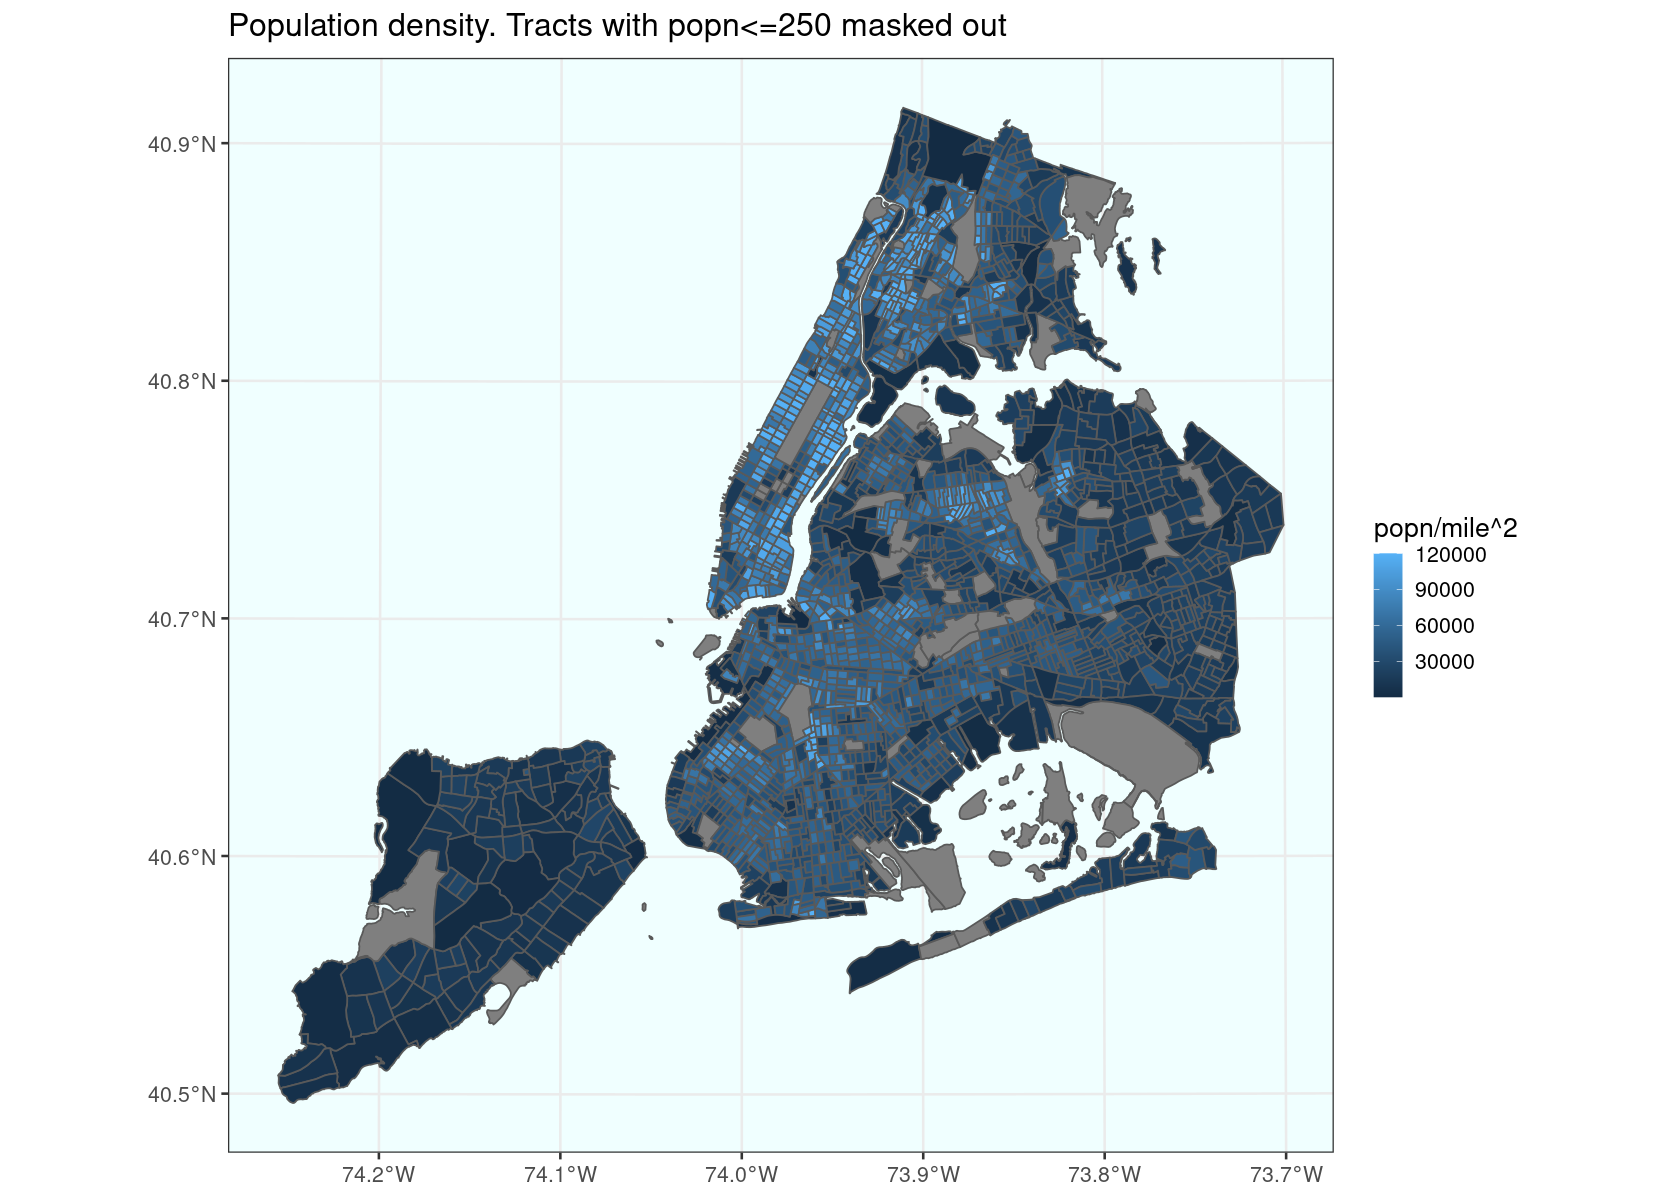

In [3]:
# Population density, from census data

df <- merge(tracts, census, by='GEOID', all.x=TRUE)
df$area <- set_units(st_area(df), 'mile ^2')
df$density <- df$popn / as.numeric(df$area)

options(repr.plot.width=14, repr.plot.height=10)

ggplot() + 
  geom_sf(data=df, aes(fill=ifelse(popn>250,pmin(density,120000),NA))) +
  with(as.list(st_bbox(df)), coord_sf(xlim=c(xmin,xmax), ylim=c(ymin,ymax))) +
  guides(fill=guide_colourbar(title='popn/mile^2')) +
  ggtitle('Population density. Tracts with popn<=250 masked out') +
  theme_bw(base_size=16) +
  theme(panel.background = element_rect(fill='azure'))

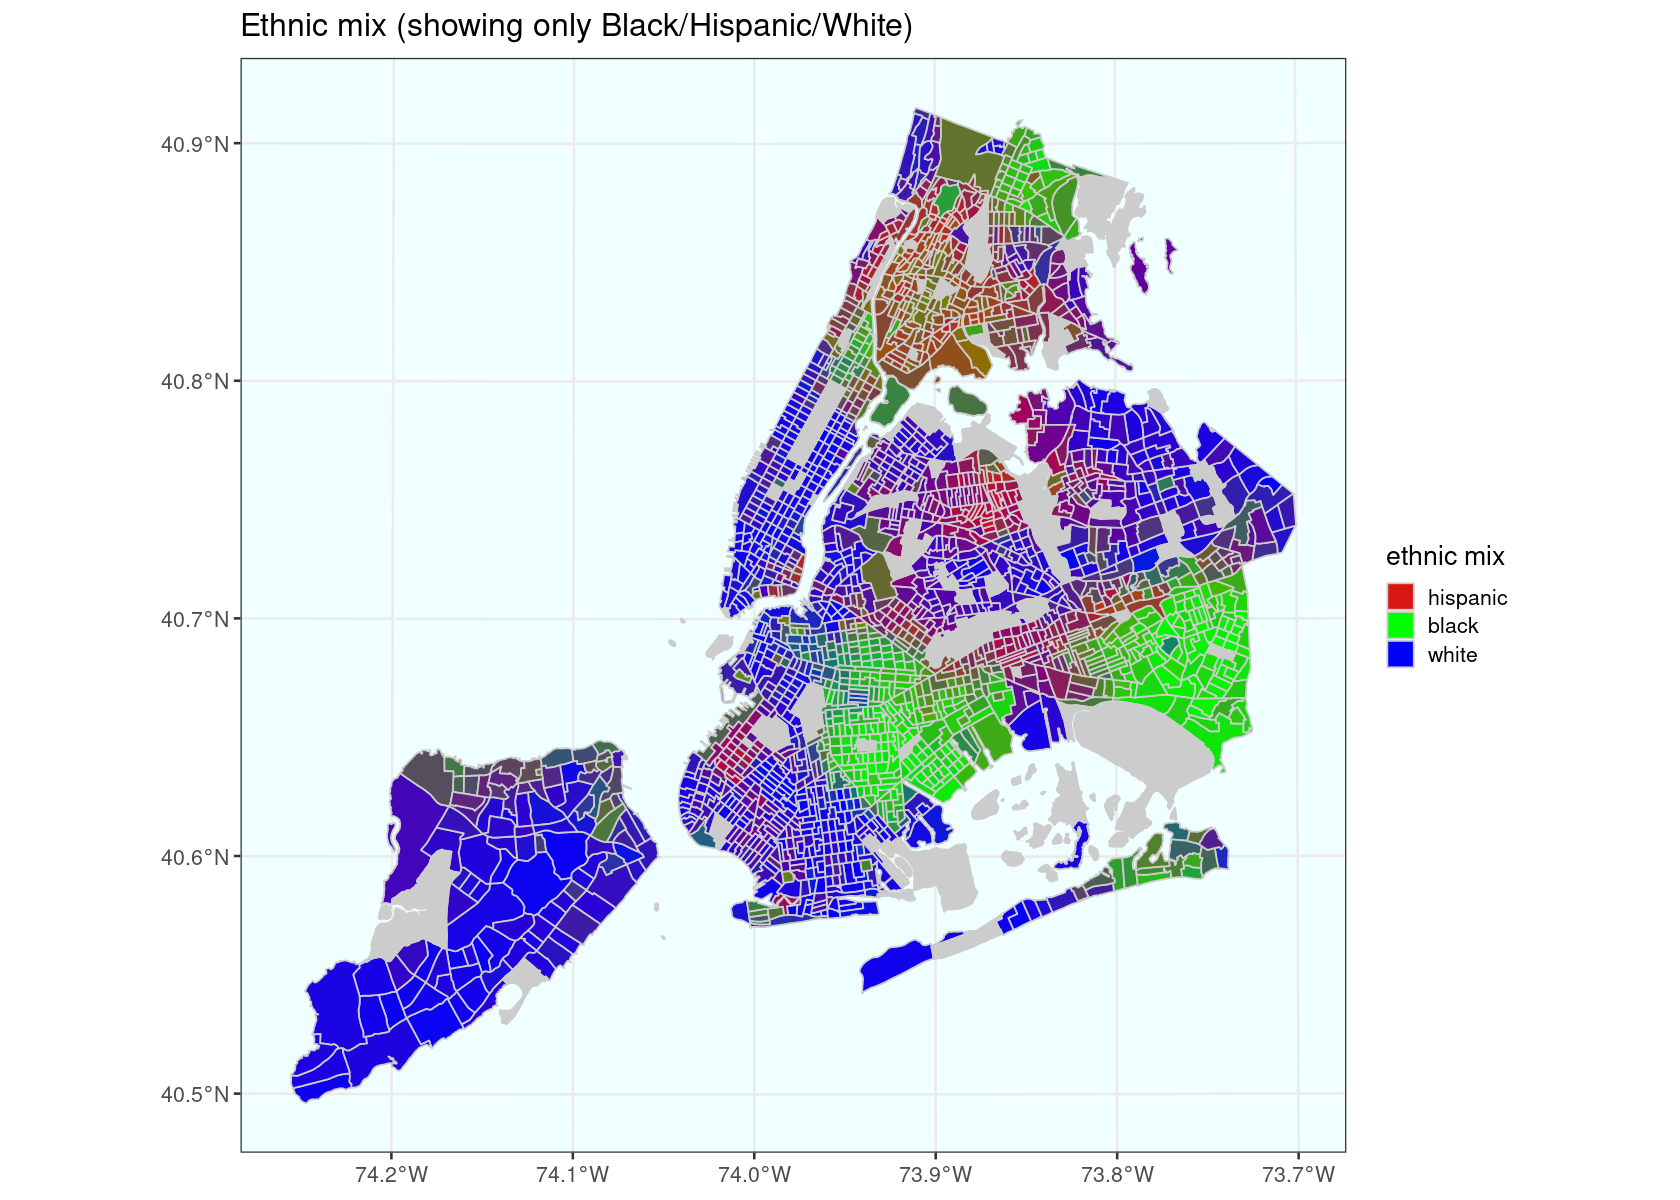

In [4]:
# Ethnic mix (black, hispanic, white)

df <- merge(census, camera_count, by='GEOID', all=TRUE)
df <- merge(df, as.data.table(st_drop_geometry(tracts))[, list(GEOID, borough)], by='GEOID', all=TRUE)

# Colour-code by three-way split, Hispanic / Black / White.
df[, popn2 := ifelse(popn>250, popn.black + popn.hispanic + popn.white, Inf)]
λ.h <- df[, popn.hispanic / popn2]
λ.w <- df[, popn.white / popn2]
λ.b <- df[, popn.black / popn2]
df[, ethcol := rgb(λ.h, λ.b, λ.w)]
eth_guide <- df[c(which.max(λ.h), which.max(λ.b), which.max(λ.w))]
eth_guide[, label := c('hispanic','black','white')]

dft <- merge(tracts[,'GEOID'], df, by='GEOID')

options(repr.plot.width=14, repr.plot.height=10)

ggplot() +
  geom_sf(data=dft, aes(fill=ifelse(popn>250,ethcol,'grey80')), col='grey80') +
  scale_fill_identity(guide='legend', breaks=eth_guide$ethcol, labels=eth_guide$label) +
  guides(fill=guide_legend(title='ethnic mix')) +
  ggtitle('Ethnic mix (showing only Black/Hispanic/White)') +
  theme_bw(base_size=16) +
  theme(panel.background = element_rect(fill='azure'))

### STOP+FRISK

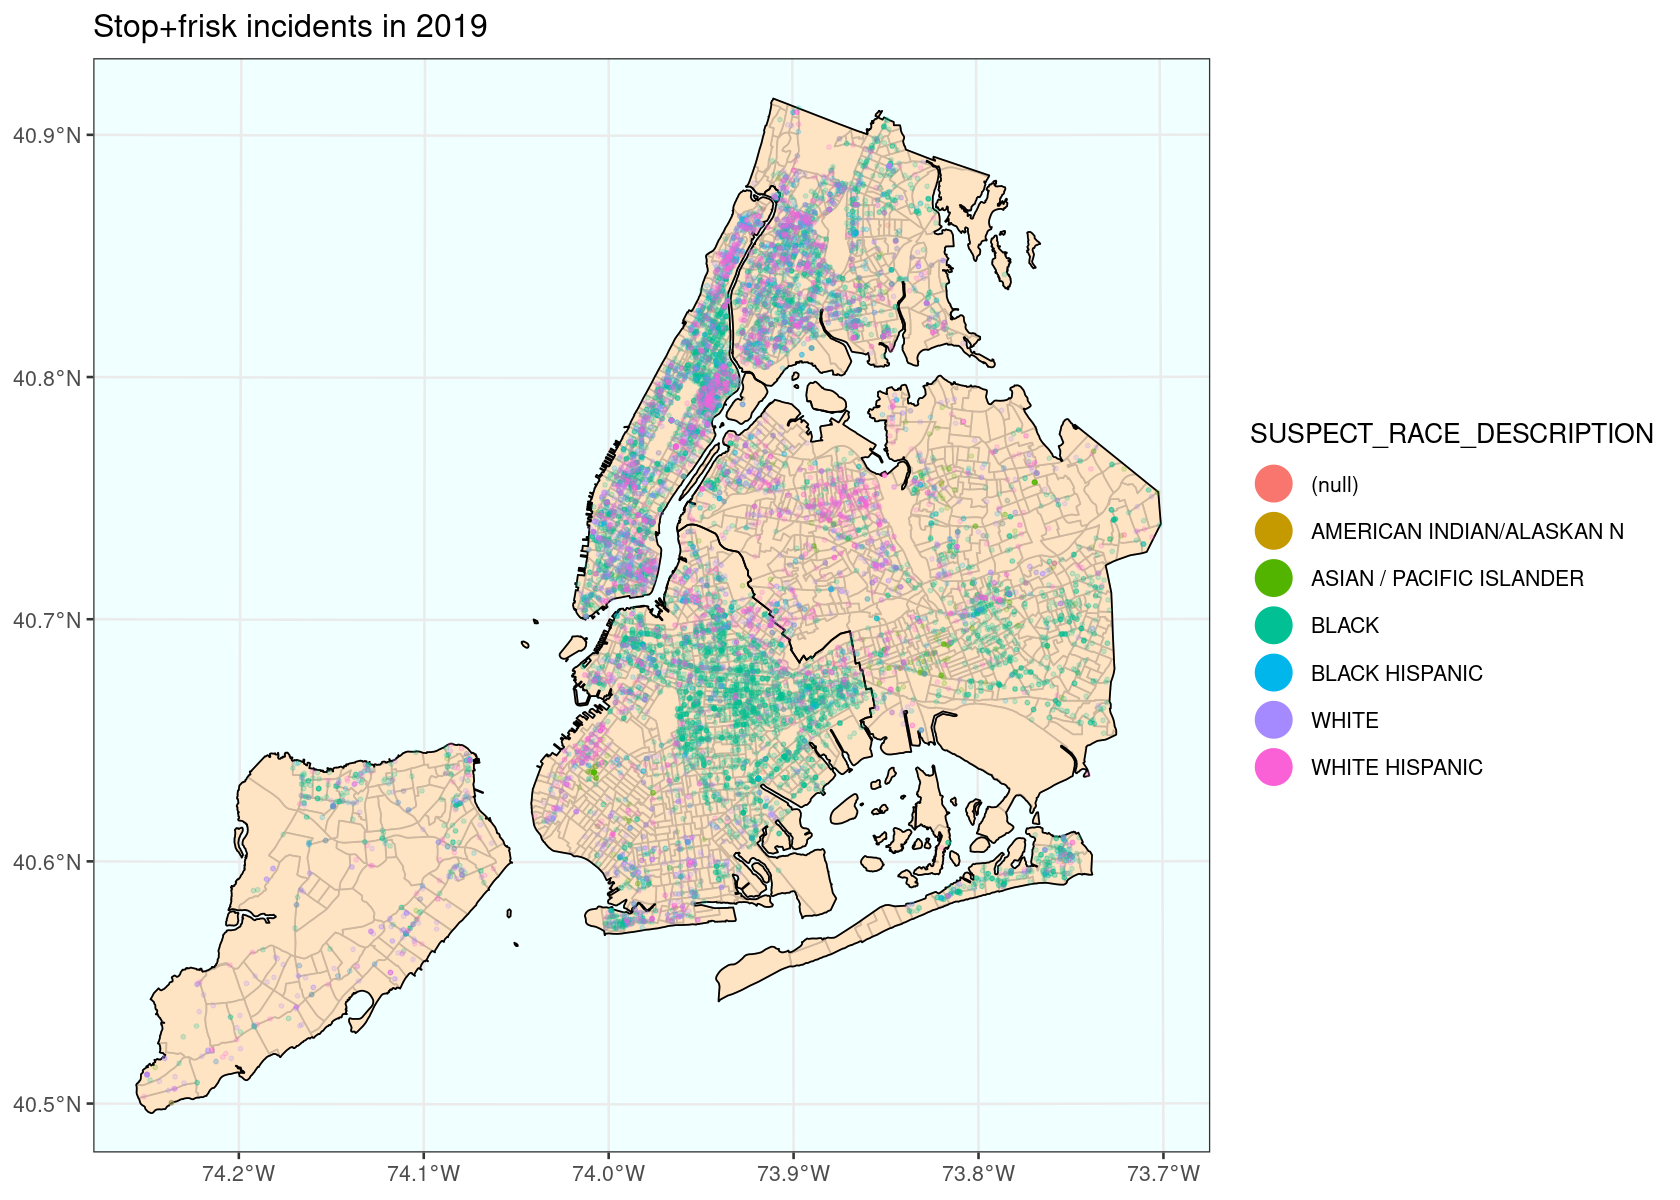

In [6]:
# Stop+frisk incidents

options(repr.plot.width=14, repr.plot.height=10)

ggplot() + 
  geom_sf(data=tracts, colour='bisque3', fill='bisque') +
  geom_sf(data=BOROUGH, colour='black', fill=NA) +
  geom_sf(data=sqf[sqf$YEAR2==2019,], aes(col=SUSPECT_RACE_DESCRIPTION), alpha=.2, size=1) +
  with(as.list(st_bbox(sqf)), coord_sf(xlim=c(xmin,xmax), ylim=c(ymin,ymax))) +
  guides(colour = guide_legend(override.aes=list(alpha=1, size=10))) +
  ggtitle('Stop+frisk incidents in 2019') +
  theme_bw(base_size=16) +
  theme(panel.background = element_rect(fill='azure'))

### SURVEILLANCE

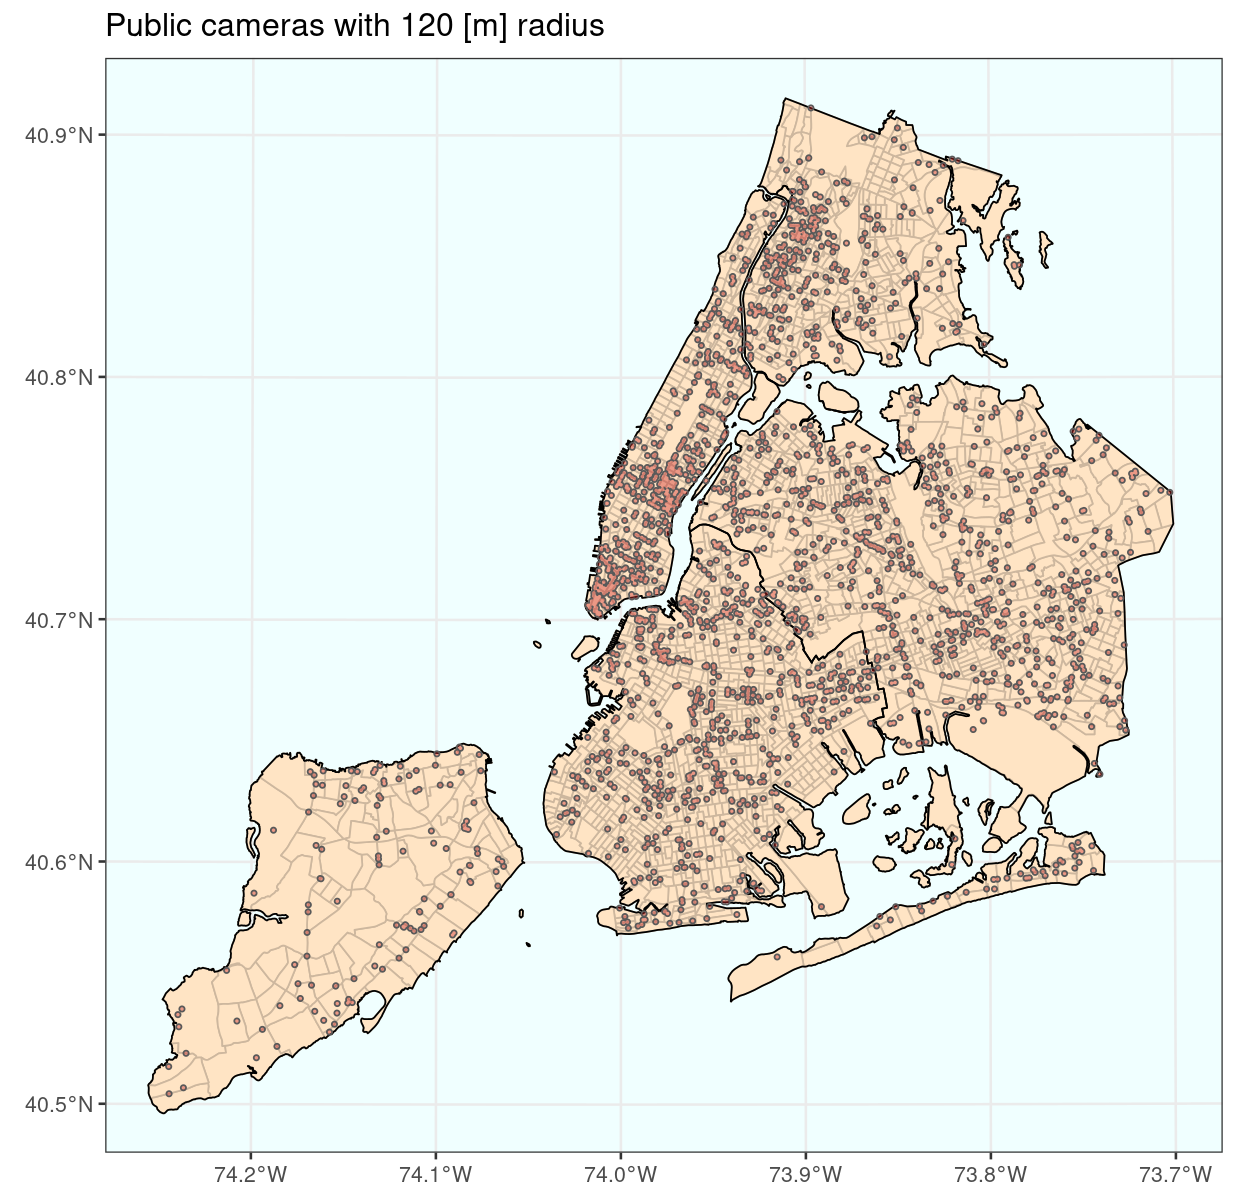

In [5]:
# Public camera locations

options(repr.plot.width=10.4, repr.plot.height=10)

camera_coverage <- st_union(st_buffer(camera[camera$public,], dist=CAMERA_RADIUS))

ggplot() + 
  geom_sf(data=tracts, colour='bisque3', fill='bisque') +
  geom_sf(data=BOROUGH, colour='black', fill=NA) +
  geom_sf(data=camera_coverage, fill='firebrick3', alpha=.4) +
  with(as.list(st_bbox(sqf)), coord_sf(xlim=c(xmin,xmax), ylim=c(ymin,ymax))) +
  ggtitle(paste('Public cameras with',format(CAMERA_RADIUS),'radius')) +
  theme_bw(base_size=16) +
  theme(panel.background=element_rect(fill='azure'))

### SURVEILLANCE / POPULATION

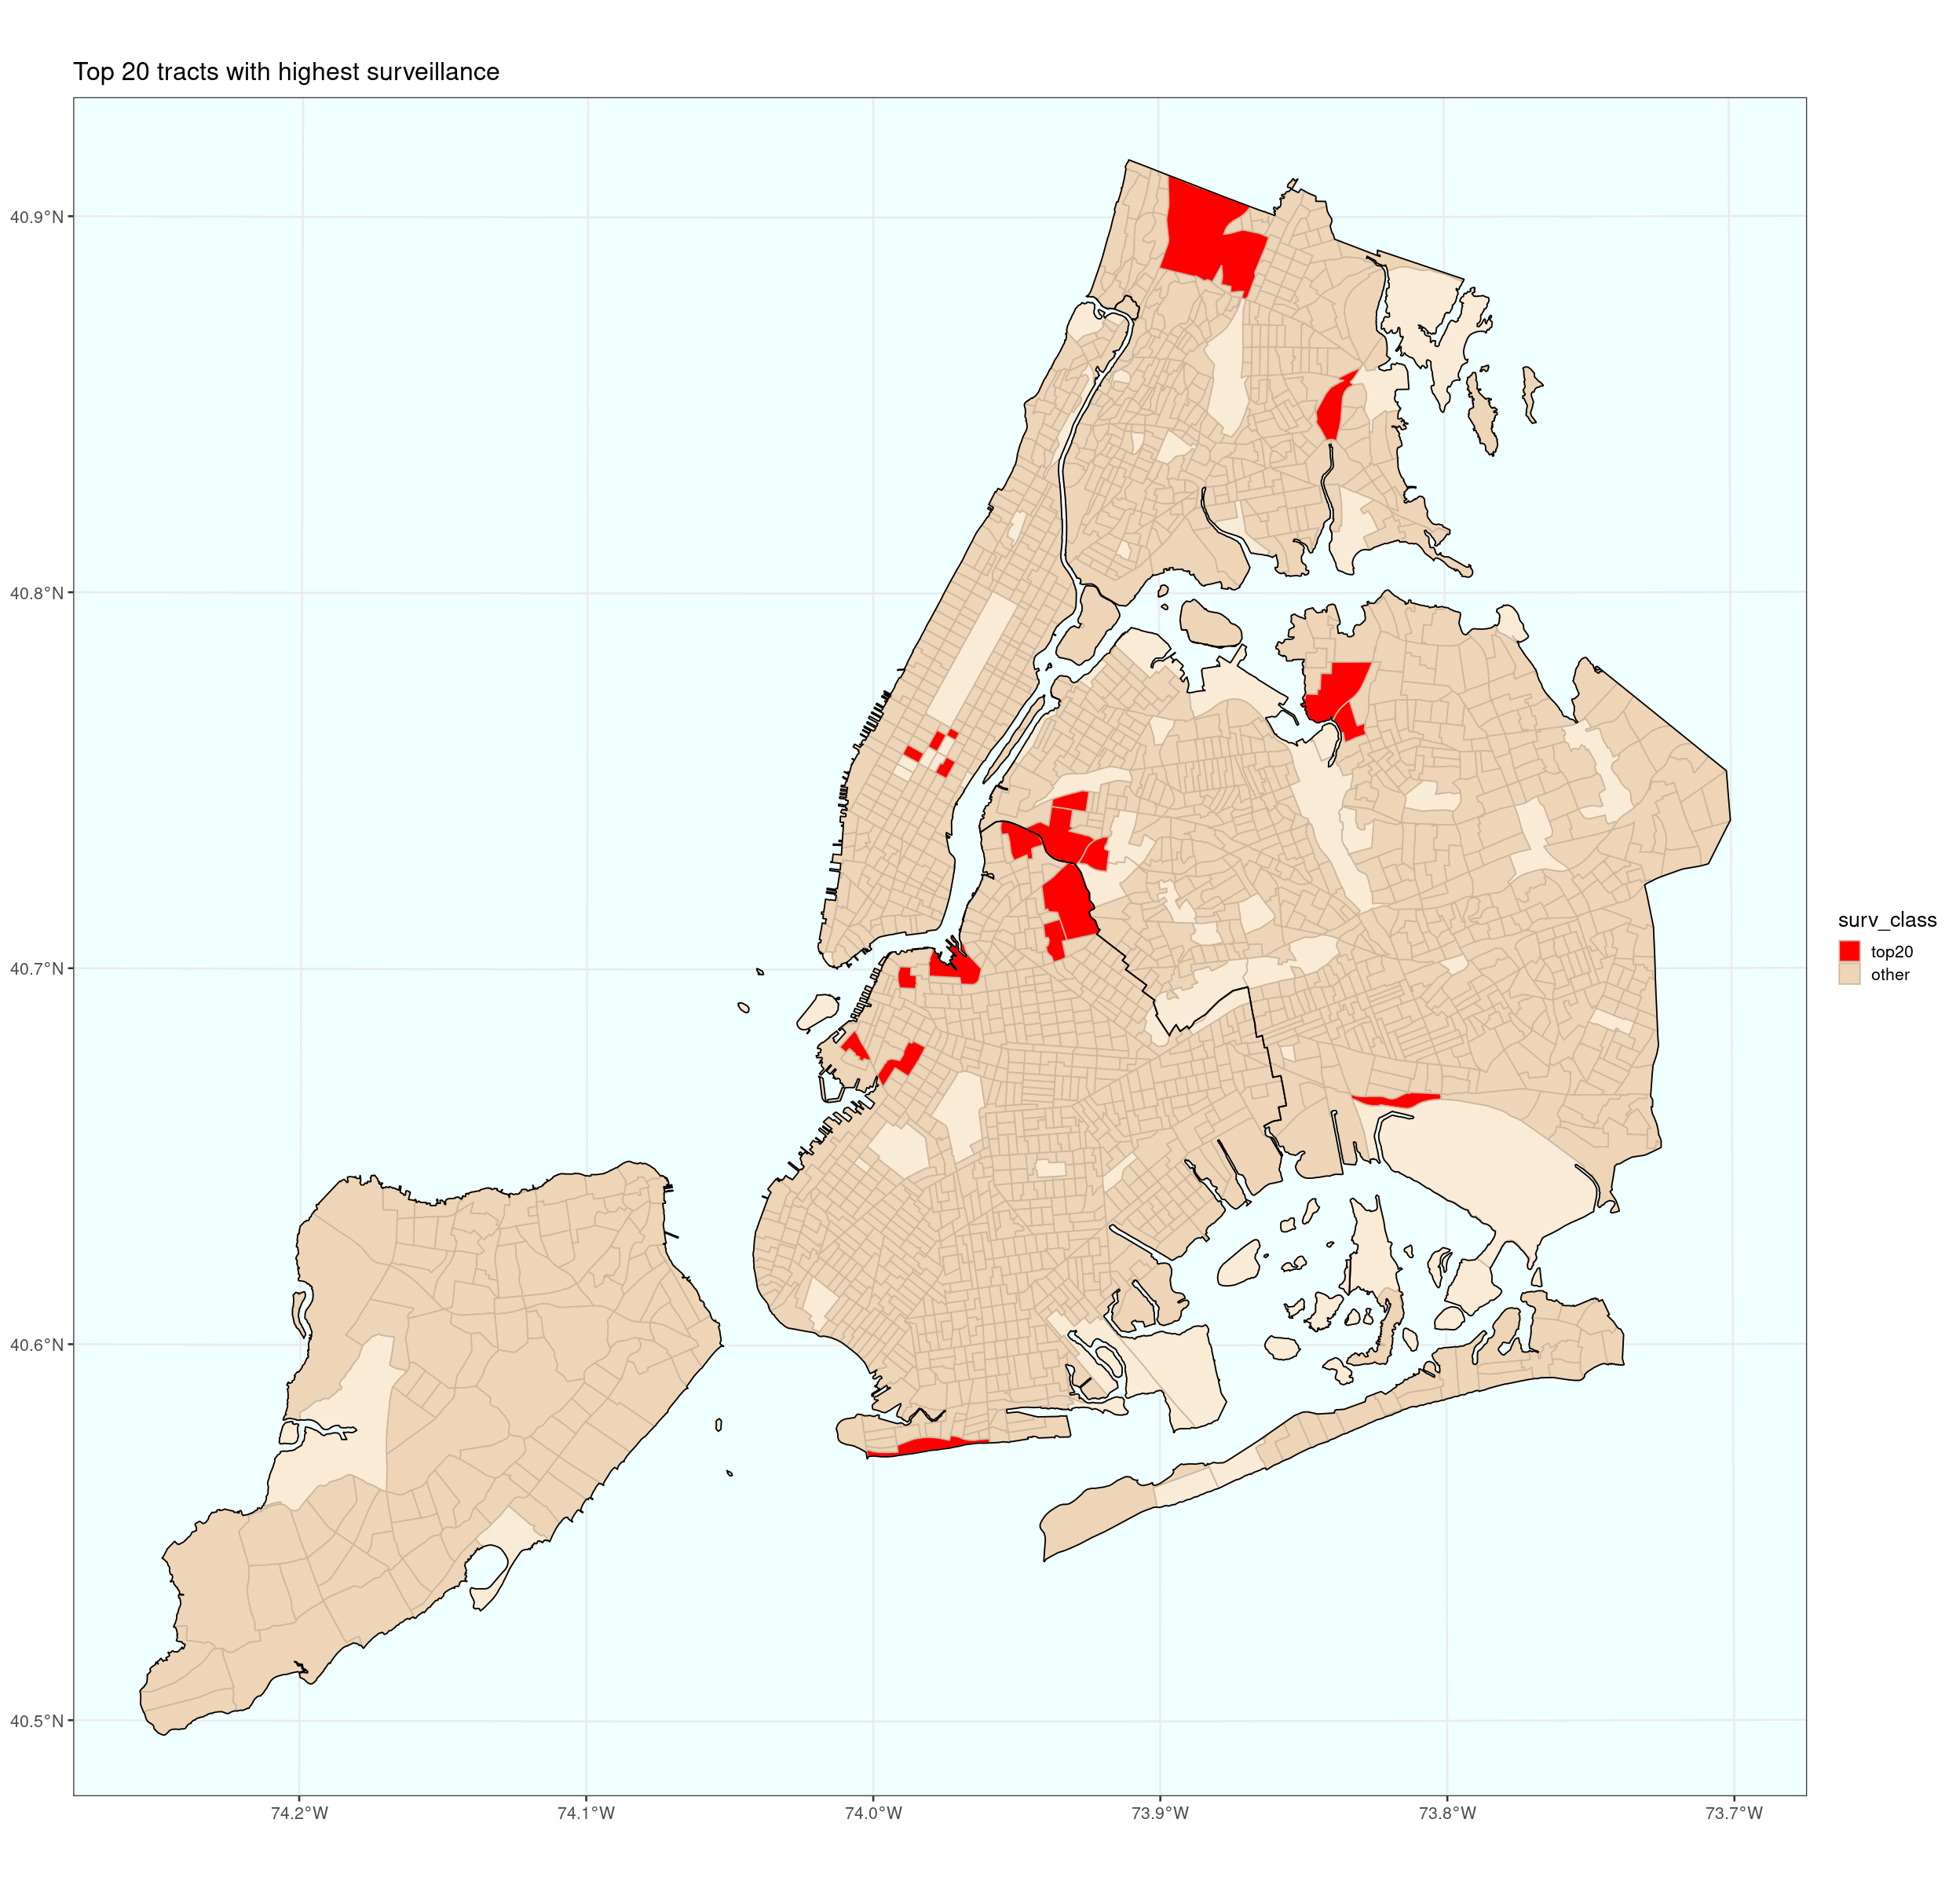

In [98]:
# Which tracts have the highest surveillance levels?
# (surveillance level = effective number of cameras per 1000 residents)
# Only look at tracts with popn > 250, to exclude non-residential areas.

df <- merge(census, camera_count, by='GEOID', all=TRUE)
df[, surv := eff_cameras / popn * 1000]
df[, surv_rank := rank(-surv), by=popn>250]
df[, surv_class := ifelse(popn>250, ifelse(surv_rank<=20,'top20','other'), NA)]
df <- merge(tracts[,c('GEOID','NAMELSAD','borough')], df, by='GEOID', all=TRUE)
st_agr(df) <- 'constant'
# Get a Google Maps url for the centroid of the tract
df2 <- st_centroid(df[,'GEOID'])
df2 <- st_transform(df2, crs='epsg:4326')
df2 <- cbind(data.table(GEOID=df2$GEOID), st_coordinates(df2))
df2[, url := paste0('http://maps.google.com/maps?z=12&t=m&q=loc:',Y,'+',X)]
df <- merge(df, df2[, list(GEOID,url)], by='GEOID', all=TRUE)

options(repr.plot.width=20.8, repr.plot.height=20)

ggplot() + 
  geom_sf(data=df, aes(fill=surv_class), colour='bisque3') +
  geom_sf(data=BOROUGH, colour='black', fill=NA) +
  scale_fill_manual(values=c('top20'='red', 'other'='bisque2'), na.value='antiquewhite') +
  with(as.list(st_bbox(sqf)), coord_sf(xlim=c(xmin,xmax), ylim=c(ymin,ymax))) +
  ggtitle('Top 20 tracts with highest surveillance') +
  theme_bw(base_size=16) +
  theme(panel.background=element_rect(fill='azure'))

In [99]:
# The top 50 most surveilled census tracts (excluding those with popn <= 250)

as.data.table(df)[popn>250 & surv_rank<=50][order(surv_rank), list(GEOID,NAMELSAD,borough,popn,eff_cameras,surv_rank,url)]

GEOID       NAMELSAD             borough   popn eff_cameras surv_rank
1  36047054300 Census Tract 543     Brooklyn   283 2.4232144    1       
2  36081019900 Census Tract 199     Queens     697 4.9148482    2       
3  36081017900 Census Tract 179     Queens    1019 4.7119249    3       
4  36061011202 Census Tract 112.02  Manhattan  415 1.6862763    4       
5  36081090700 Census Tract 907     Queens    1434 5.7624049    5       
6  36081084602 Census Tract 846.02  Queens     925 3.5133866    6       
7  36005028400 Census Tract 284     Bronx      554 1.5409576    7       
8  36047044900 Census Tract 449     Brooklyn  3210 8.9022172    8       
9  36061011900 Census Tract 119     Manhattan 1071 2.9550138    9       
10 36061010400 Census Tract 104     Manhattan  811 2.1815545   10       
11 36061009200 Census Tract 92      Manhattan 1474 3.9182786   11       
12 36047057900 Census Tract 579     Brooklyn  1165 3.0745038   12       
13 36005043500 Census Tract 435     Bronx      499 1.2030816   13       
14 36047011900 Census Tract 119     Brooklyn  1322 3.0205297   14       
15 36047035200 Census Tract 352     Brooklyn  1254 2.8244718   15       
16 36081086900 Census Tract 869     Queens    1771 3.8132589   16       
17 36081020500 Census Tract 205     Queens    1176 2.3714092   17       
18 36047005900 Census Tract 59      Brooklyn  1213 2.4192464   18       
19 36047001300 Census Tract 13      Brooklyn  1917 3.7913915   19       
20 36047048500 Census Tract 485     Brooklyn  2289 4.5043668   20       
21 36047109800 Census Tract 1098    Brooklyn  2359 4.3413446   21       
22 36061003700 Census Tract 37      Manhattan 2666 4.7583208   22       
23 36081008500 Census Tract 85      Queens     883 1.5557916   23       
24 36005006300 Census Tract 63      Bronx     4582 7.7866877   24       
25 36061000900 Census Tract 9       Manhattan 1796 2.9950564   25       
26 36005011700 Census Tract 117     Bronx     1443 2.3350008   26       
27 36047001800 Census Tract 18      Brooklyn  1897 3.0655438   27       
28 36061019701 Census Tract 197.01  Manhattan  639 1.0125440   28       
29 36081029300 Census Tract 293     Queens    1090 1.6693786   29       
30 36005001900 Census Tract 19      Bronx     3141 4.7729450   30       
31 36061004500 Census Tract 45      Manhattan  980 1.4861464   31       
32 36061011203 Census Tract 112.03  Manhattan 1103 1.6466061   32       
33 36061001300 Census Tract 13      Manhattan 4455 6.6253457   33       
34 36061003100 Census Tract 31      Manhattan 2525 3.6979451   34       
35 36061011401 Census Tract 114.01  Manhattan 1173 1.6631851   35       
36 36081020800 Census Tract 208     Queens    3136 4.3191795   36       
37 36081003300 Census Tract 33      Queens    3569 4.8857703   37       
38 36061010100 Census Tract 101     Manhattan 1373 1.8746598   38       
39 36047003500 Census Tract 35      Brooklyn  1907 2.5967407   39       
40 36061012500 Census Tract 125     Manhattan 2311 3.1256031   40       
41 36047036700 Census Tract 367     Brooklyn  1281 1.7225404   41       
42 36061010000 Census Tract 100     Manhattan 1741 2.3397171   42       
43 36047004700 Census Tract 47      Brooklyn  1877 2.4798944   43       
44 36047079400 Census Tract 794     Brooklyn  1716 2.2276285   44       
45 36081042600 Census Tract 426     Queens     477 0.6125966   45       
46 36081066300 Census Tract 663     Queens    2771 3.5518514   46       
47 36081148300 Census Tract 1483    Queens    2900 3.6298691   47       
48 36061009900 Census Tract 99      Manhattan 5981 7.3855809   48       
49 36081140901 Census Tract 1409.01 Queens     990 1.2021309   49       
50 36005028600 Census Tract 286     Bronx     1085 1.3108964   50       
   url                                                                          
1  http://maps.google.com/maps?z=12&t=m&q=loc:40.7009021108811+-73.9711860731856
2  http://maps.google.com/maps?z=12&t=m&q=loc:40.7351969475049+-73.9340362079201
3  http://maps.google.com/maps?z=12&t

## 1. The number of stop+frisk incidents is closely linked to the level of surveillance

We first analyze how the number of stop+frisk incidents depends on the number of cameras. The underlying statistical model 
we'll use is a generalized linear model,
$$
\text{average num.stops in tract} = \lambda \times \text{tract.popn}/1000,
$$
Here $\lambda$ is the rate of stop+frisk incidents per 1000 population, and the focus of the analysis is to understand how λ depends on level of surveillance.

Furthermore, we'll model the actual number of stops as a Poisson random variable, with mean as specified above.
This is a standard statistical model for analyzing count data. 

We split the tracts into 9 groups, according to level of surveillance, and estimate λ separately for each group. (This allows us to assess the relationship between stop+frisk and surveillance, without assuming any particular form of the equation.) For this analysis, surveillance level is defined as the effective number of cameras within 200m of a given census tract, per 1000 residents.
We see that the stop+frisk rate λ increases with the level of surveillance, and the relationship is roughly linear.

Our analysis uses data for 2019. We restrict attention to census tracts with a population of >250, as a simple way to exclude parks etc.

In [7]:
df <- as.data.table(expand.grid(GEOID=unique(census$GEOID), YEAR2=unique(sqf$YEAR2)))
df <- merge(df, as.data.table(sqf)[, list(numstops=.N), by=list(GEOID,YEAR2)], all=TRUE) # numstops per tract,year
df <- merge(df, census, by='GEOID', all=TRUE) # popn, popn.black, popn.hispanic, popn.white
df <- merge(df, camera_count, by='GEOID', all=TRUE) # eff_cameras_within_200m and other counts
df <- merge(df, as.data.table(st_drop_geometry(tracts))[, list(GEOID, borough)], by='GEOID', all=TRUE) # borough
df[is.na(numstops), numstops := 0] # for the tracts with no recorded stops

# Let stoprate = number of stops per 1000 residents in a census tract
# Let surv by the effective number of cameras within 200m of the tract, per 1000 residents

df[, stoprate := numstops/popn*1000]
df[, surv := eff_cameras_within_200m/popn*1000]

# For a non-parametric model, it's useful to split the tracts into separate groups
# according to surveillance level. Let survF be a split version of surv.

breaks <- c(seq(0,1.5,by=.25), 2, 3)
break_midpoint <- c((tail(breaks,-1) + head(breaks,-1)) / 2, 3.5)
df[, survF := cut(surv, breaks=c(breaks,Inf), labels=break_midpoint, include.lowest=TRUE)]
breaks

[1] 0.00 0.25 0.50 0.75 1.00 1.25 1.50 2.00 3.00

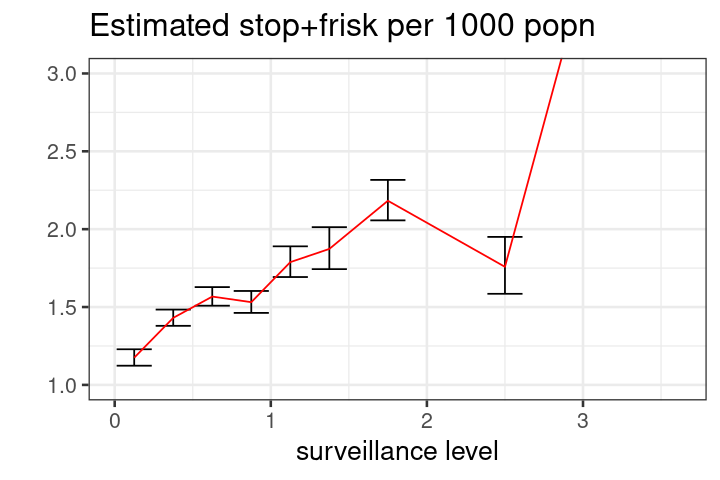

In [8]:
# Estimate λ as a function of level of surveillance (using survF, our discretized version
# of level-of-surveillance). The plot shows the estimates for λ as well as 95% confidence
# intervals, for each surveillance level.

fit <- glm(numstops ~ 0 + survF, offset=log(popn/1000), 
           data=df[popn>250 & YEAR2==2019],
           family='poisson')
x <- as.data.table(coef(summary(fit)))
x[, stoprate := exp(Estimate)]
x[, lo := exp(Estimate-1.96*`Std. Error`)]
x[, hi := exp(Estimate+1.96*`Std. Error`)]
x[,'survF' := levels(df$survF)]

options(repr.plot.width=6, repr.plot.height=4)

ggplot(data=x) +
  geom_errorbar(aes(x=as.numeric(survF), ymin=lo, ymax=hi)) +
  geom_line(aes(x=as.numeric(survF), y=stoprate), colour='red') +
  xlab('surveillance level') + ylab('') +
  ggtitle('Estimated stop+frisk per 1000 popn') +
  coord_cartesian(ylim=c(1,3))

#### SANITY CHECKS

Here are some plots that support the underlying statistical model described above.

The first plot shows that the stop+frisk rate (number of stops per 1000 residents) grows with the surveillance level.
This plot is very noisy.

The second and third plots show why there is so much noise. The actual number of stops in a given census tract is a small integer,
mostly in the range 0-10, and so there is bound to be lots of noise in the data for a single census tract. The second plot supports the idea that the number of stop+frisk incidents is proportional to population, and the third plot is consistent with a Poisson model.

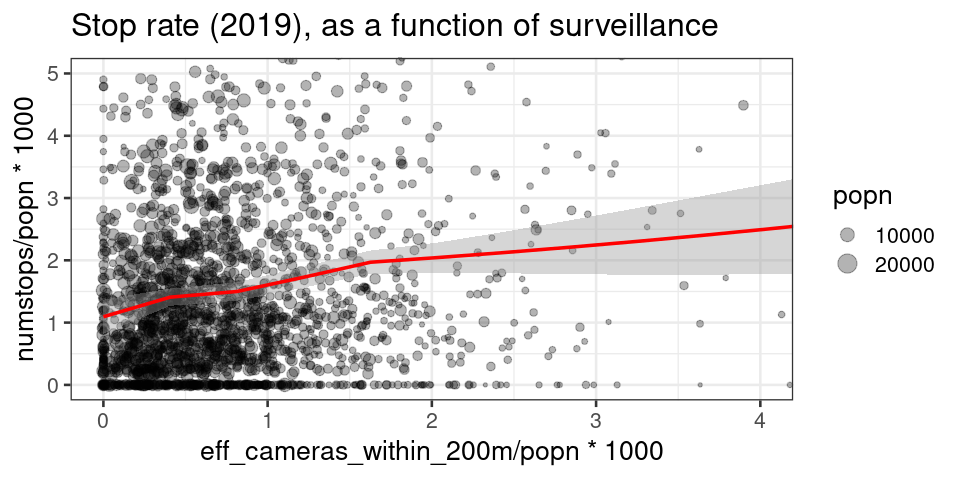

In [9]:
options(repr.plot.width=8, repr.plot.height=4)

ggplot(data=df[popn>250 & YEAR2==2019], aes(y=numstops/popn*1000, x=eff_cameras_within_200m/popn*1000)) +
  geom_point(aes(size=popn), alpha=.3) +
  geom_smooth(method='loess', colour='red', formula=y~x) +
  scale_size_area() +
  coord_cartesian(xlim=c(0,4), ylim=c(0,5)) +
  ggtitle('Stop rate (2019), as a function of surveillance')

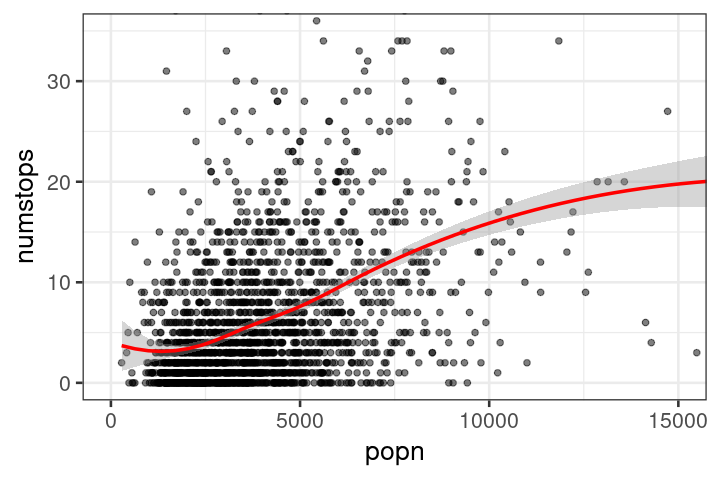

In [10]:
options(repr.plot.width=6, repr.plot.height=4)

ggplot(data=df[popn>250 & YEAR2==2019], aes(x=popn, y=numstops)) +
  geom_point(alpha=.5) +
  geom_smooth(method='loess', colour='red', formula=y~x) +
  coord_cartesian(xlim=c(0,15000), ylim=c(0,35))

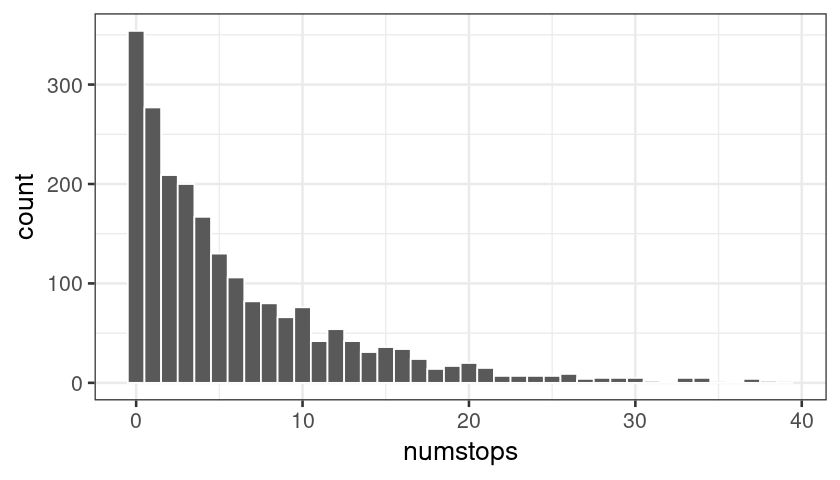

In [11]:
options(repr.plot.width=7, repr.plot.height=4)

ggplot(data=df[YEAR2==2019]) +
  geom_histogram(aes(x=numstops), colour='white', breaks=seq(-.5,40,by=1))

## 2. Stop+frisk rates also vary with racial mix, on top of the link to surveillance

What else does the stop+frisk rate depend on? As before we consider the model
$$
\text{average num.stops in tract} = \lambda \times \text{tract.popn}/1000
$$
and we investigate what λ depends on. Our baseline model is a simple generalized linear model,
$$
\log \lambda = \alpha + \beta\times \text{surveillance.level} + \gamma\times \text{nonwhite.fraction}
$$
where α, β, γ, are coefficients to be estimated from the data.

Unsurprisingly, the coefficient for surveillance level (defined as effective number of cameras within 200m of the tract per 1000 residents) is positive, and highly significant (coef=0.02, p<0.001, for Queens in 2019).

The coefficient for nonwhite.fraction (defined as the fraction of residents who identify as Black or Hispanic, out of those who identify as Black or Hispanic or White) is also positive, and highly significant (coef=0.83, p<0.001, for Queens in 2019).

The β and γ coefficients vary from borough to borough, and they are consistent from 2019 to 2020. (See the chart below for the coefficient values and 95% confidence intervals.) They are consistently positive, and consistently significant.

The fact that both β and γ are highly significant shows that they are not confounding each other. In other words, it is *not* the case that variation in stop+frisk due to surveillance level is entirely explained by the racial mix.

#### SANITY CHECKS

We developed the baseline model using data from a single borough (Queens), to avoid overfitting.
* We tested for a non-linear dependence on surveillance level, but it is not significant.
* We also tested a model with separate coefficients for black.fraction and hispanic.fraction, but the difference between these coefficients is not significant. For all our analyses below, we have therefore pooled Black and Hispanic populations.
* We also tested for an interaction between surveillance.level and nonwhite.fraction. It was not significant. (We might expect
we'd need more data to estimate an interaction effect, so we also tried pooling four boroughs excluding Manhattan, and also pooling all five boroughs. It remains not significant in both cases.)


In [12]:
df <- as.data.table(expand.grid(GEOID=unique(census$GEOID), YEAR2=unique(sqf$YEAR2)))
df <- merge(df, as.data.table(sqf)[, list(numstops=.N), by=list(GEOID,YEAR2)], all=TRUE) # numstops per tract,year
df <- merge(df, census, by='GEOID', all=TRUE) # popn, popn.black, popn.hispanic, popn.white
df <- merge(df, camera_count, by='GEOID', all=TRUE) # eff_cameras_within_200m and other counts
df <- merge(df, as.data.table(st_drop_geometry(tracts))[, list(GEOID, borough)], by='GEOID', all=TRUE) # borough
df[is.na(numstops), numstops := 0] # for the tracts with no recorded stops

# Let stoprate = number of stops per 1000 residents in a census tract
# Let surv by the effective number of cameras within 200m of the tract, per 1000 residents

df[, stoprate := numstops/popn*1000]
df[, surv := eff_cameras_within_200m/popn*1000]
df[, nonwhite_fraction := (popn.black + popn.hispanic) / (popn.black + popn.hispanic + popn.white)]

In [13]:
# The baseline model
fit0 <- glm(numstops ~ surv + nonwhite_fraction, offset=log(popn), 
            family='poisson',
            data=df[YEAR2==2019 & borough=='Queens'],
            subset=popn>250)

In [14]:
# Baseline model sanity check. Is it reasonable to assume a linear dependence on surv?
# Is it reasonable to pool Black and Hispanic?

fit1 <- update(fit0, . ~ . + I(surv^2) + I(popn.black/popn))
summary(fit1)


Call:
glm(formula = numstops ~ surv + nonwhite_fraction + I(surv^2) + 
    I(popn.black/popn), family = "poisson", data = df[YEAR2 == 
    2019 & borough == "Queens"], subset = popn > 250, offset = log(popn))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.7321  -1.6934  -0.5816   0.6344   7.4685  

Coefficients:
                    Estimate Std. Error  z value Pr(>|z|)    
(Intercept)        -7.538773   0.065070 -115.856  < 2e-16 ***
surv                0.204248   0.035519    5.750 8.90e-09 ***
nonwhite_fraction   0.832449   0.116499    7.146 8.96e-13 ***
I(surv^2)          -0.004956   0.003158   -1.569    0.117    
I(popn.black/popn)  0.087239   0.099152    0.880    0.379    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 2267.1  on 640  degrees of freedom
Residual deviance: 2037.0  on 636  degrees of freedom
AIC: 3614.9

Number of Fisher Scoring iterations: 5


In [15]:
# Further sanity check. Is there any interaction between the surveillance term and the nonwhite_fraction?
# We'll use a simple binarized version of nonwhite_fraction -- it's more robust to explore the question
# non-parametrically in the first instance, than to assume a formula.

df[, nwfC := cut(nonwhite_fraction, breaks=2)]

fit <- lm(stoprate ~ nwfC*surv,
          weight=popn,
          data=df,
          subset=popn>250 & YEAR2==2019 & borough!='Manhattan')
summary(fit)


Call:
lm(formula = stoprate ~ nwfC * surv, data = df, subset = popn > 
    250 & YEAR2 == 2019 & borough != "Manhattan", weights = popn)

Weighted Residuals:
    Min      1Q  Median      3Q     Max 
-174.08  -51.15  -19.24   28.41  831.22 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)       0.52090    0.07330   7.106 1.71e-12 ***
nwfC(0.5,1]       0.83911    0.09913   8.465  < 2e-16 ***
surv              0.52639    0.07327   7.185 9.78e-13 ***
nwfC(0.5,1]:surv  0.04881    0.09851   0.495     0.62    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 87.59 on 1823 degrees of freedom
Multiple R-squared:  0.1434,	Adjusted R-squared:  0.142 
F-statistic: 101.7 on 3 and 1823 DF,  p-value: < 2.2e-16


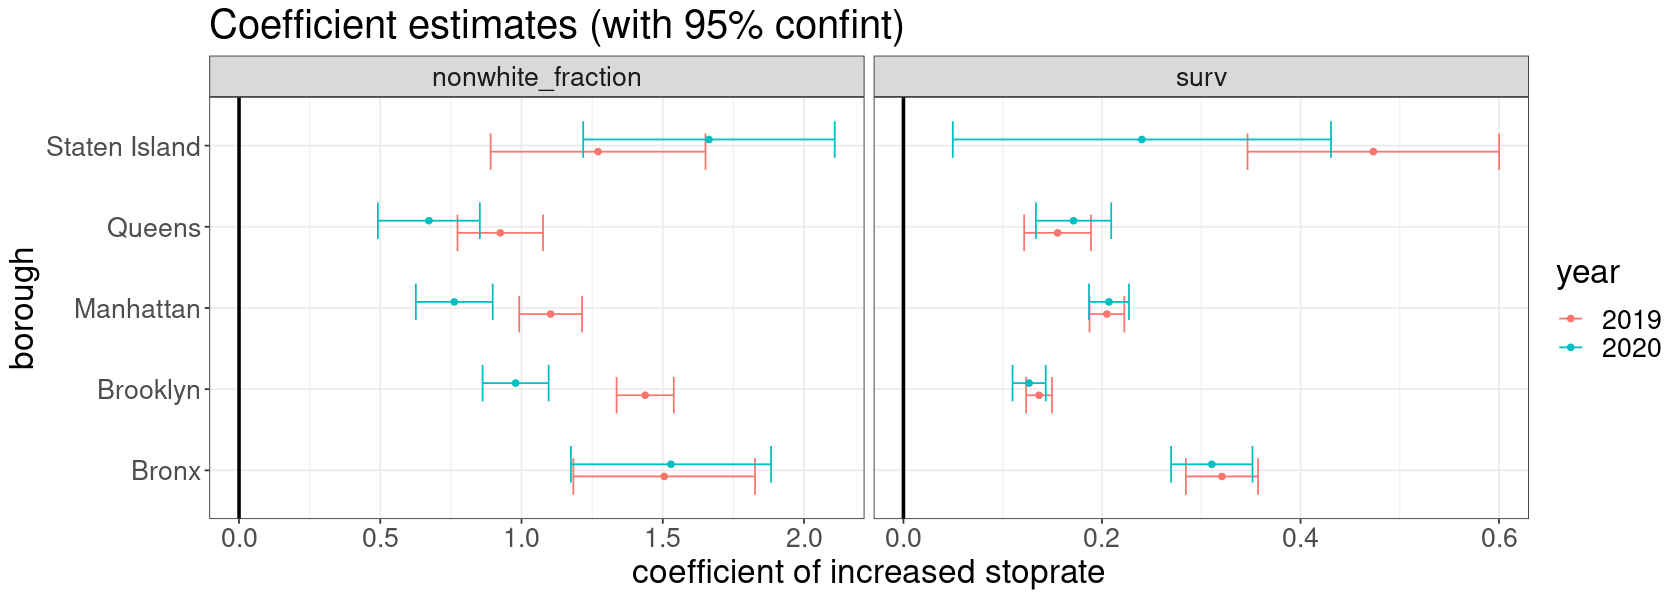

In [16]:
# How do the coefficients vary from year to year, and borough to borough?

resdf <- as.data.table(expand.grid(YEAR2=unique(df$YEAR2), borough=unique(df$borough)))

resdf <- mapply(resdf$YEAR2, resdf$borough, SIMPLIFY=FALSE, FUN=function(y,b) {
  fit <- update(fit0, data=df[YEAR2==y & borough==b])
  x <- coef(summary(fit))
  data.table(YEAR2=y, borough=b, coef=dimnames(x)[[1]], Estimate=x[,'Estimate'], se=x[,'Std. Error'])
})
resdf <- do.call(rbind, resdf)
resdf[, year := factor(YEAR2)]

options(repr.plot.width=14, repr.plot.height=5)

ggplot(data=resdf[coef!='(Intercept)']) + 
  geom_vline(xintercept=0, size=1, color='black') +
  geom_errorbarh(aes(xmin=Estimate-1.96*se, xmax=Estimate+1.96*se, y=borough,col=year), position=position_dodge(0.3)) +
  geom_point(aes(x=Estimate, y=borough, col=year), position=position_dodge(0.3)) + 
  facet_wrap(~coef, scales='free_x') +
  theme_bw() + theme(text=element_text(size=20)) +
  ggtitle('Coefficient estimates (with 95% confint)') +
  xlab('coefficient of increased stoprate')

## 3. How does surveillance depend on demographics etc.?

We have seen that stop+frisk rates depend separately on surveillance level and on the proportion of nonwhite residents. We now investigate what surveillance level depends on.

For these analyses we'll measure surveillance level by effective number of cameras per 1000 residents in a census tract. As before we assign each camera a radius of 120m, and we measure the total area visible, then divide by the area visible by a single camera. In this section we're analysing the attributes of each area of the city, so we'll measure the area surveilled within each census tract (`eff_cameras/popn`). This in contrast to the earlier analyses of stop+frisk counts, where we analysed the attributes of residents, and we measured the area surveilled within a neighbourhood of the census tract (`eff_cameras_within_200m/popn`).

* In Manhatten, the higher nonwhite_fraction, the lower the level of surveillance (p<0.001).
* In Bronx (p=0.053), Brooklyn (p=0.027), and Queens (p=0.015), the higher the nonwhite_fraction, the higher the level of surveillance
* In Staten Island, no significant relationship (p=0.082).

When we take accout of poverty (`. ~ . + borough:med.income`), the findings point in the same direction, though they are less significant.
This suggests there is some degree of confounding, since there is more poverty linked with greater proportion of nonwhite residents.

Manhattan is most likely a special case: it's a transport hub, so there are many non-resident occupants, and policing e.g. surveillance  may well be linked to the number of occupants rather than residents.

#### MODEL CHOICE

The analyses are based on logistic regression. Surveillance level is most definitely non-Gaussian (it's truncated at zero -- see the histogram below), so it's not sound to fit a linear regression. Instead, we have binarized it into low versus high, with a threshold of 0.18 cameras per 1000 residents (close to the median). This is a simple way to get robust results.

Our baseline model is
$$
\operatorname{logit} \operatorname{Prob}(\text{high}) = \alpha_{\text{borough}} + \beta_{\text{borough}} \times \text{nonwhite_fraction}
$$
and we are interested in the β coefficients, one for each borough.

In [17]:
df <- merge(census, camera_count, by='GEOID', all=TRUE)
df <- merge(df, as.data.table(st_drop_geometry(tracts))[, list(GEOID, borough)], by='GEOID', all=TRUE)
df[, nonwhite_fraction := (popn.black + popn.hispanic) / (popn.black + popn.hispanic + popn.white)]
df[, surv := eff_cameras / popn * 1000]
df[, survF := ifelse(surv < quantile(surv, 2/3, na.rm=TRUE), 'low', 'high')]

SURV_THRESHOLD <- 0.2

In [18]:
# The baseline model

fit <- glm(surv > SURV_THRESHOLD ~ 0 + borough + borough:nonwhite_fraction, 
           data=df, subset=popn>250,
          family='binomial')
summary(fit)


Call:
glm(formula = surv > SURV_THRESHOLD ~ 0 + borough + borough:nonwhite_fraction, 
    family = "binomial", data = df, subset = popn > 250)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5946  -1.0872  -0.8329   1.1893   1.8189  

Coefficients:
                                       Estimate Std. Error z value Pr(>|z|)    
boroughBronx                            -1.6062     0.5452  -2.946  0.00321 ** 
boroughBrooklyn                         -0.5881     0.1384  -4.249 2.15e-05 ***
boroughManhattan                         0.3219     0.2016   1.597  0.11025    
boroughQueens                           -0.1307     0.1747  -0.748  0.45419    
boroughStaten Island                    -0.3403     0.3307  -1.029  0.30348    
boroughBronx:nonwhite_fraction           1.2966     0.6702   1.935  0.05301 .  
boroughBrooklyn:nonwhite_fraction        0.5029     0.2268   2.217  0.02662 *  
boroughManhattan:nonwhite_fraction      -1.7864     0.4529  -3.944 8.00e-05 ***
borough

In [19]:
# What if surveillance is related to poverty levels instead?
# Doesn't look like it.

fit2 <- update(fit, . ~ . + med.income)
summary(fit2)


Call:
glm(formula = surv > SURV_THRESHOLD ~ borough + med.income + 
    borough:nonwhite_fraction - 1, family = "binomial", data = df, 
    subset = popn > 250)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5694  -1.0901  -0.8293   1.1998   1.8380  

Coefficients:
                                         Estimate Std. Error z value Pr(>|z|)    
boroughBronx                           -1.504e+00  5.929e-01  -2.537 0.011177 *  
boroughBrooklyn                        -4.437e-01  2.076e-01  -2.137 0.032564 *  
boroughManhattan                        5.941e-01  3.496e-01   1.699 0.089305 .  
boroughQueens                           1.157e-02  2.299e-01   0.050 0.959853    
boroughStaten Island                   -1.356e-01  3.857e-01  -0.352 0.725108    
med.income                             -1.746e-06  1.810e-06  -0.965 0.334749    
boroughBronx:nonwhite_fraction          1.270e+00  7.014e-01   1.811 0.070181 .  
boroughBrooklyn:nonwhite_fraction       4.358e-01  2.

In [20]:
# We should consider unpacking %non-white into black & hispanic.
# As before, there's no signficant difference.

fit3 <- update(fit, . ~ . + I((popn.black - popn.hispanic)/popn))
summary(fit3)


Call:
glm(formula = surv > SURV_THRESHOLD ~ borough + I((popn.black - 
    popn.hispanic)/popn) + borough:nonwhite_fraction - 1, family = "binomial", 
    data = df, subset = popn > 250)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6017  -1.0849  -0.8297   1.1824   1.8063  

Coefficients:
                                       Estimate Std. Error z value Pr(>|z|)    
boroughBronx                           -1.57222    0.54729  -2.873  0.00407 ** 
boroughBrooklyn                        -0.56567    0.14415  -3.924 8.70e-05 ***
boroughManhattan                        0.32716    0.20178   1.621  0.10493    
boroughQueens                          -0.09321    0.18748  -0.497  0.61905    
boroughStaten Island                   -0.33022    0.33120  -0.997  0.31874    
I((popn.black - popn.hispanic)/popn)    0.08104    0.14687   0.552  0.58110    
boroughBronx:nonwhite_fraction          1.27483    0.66973   1.903  0.05698 .  
boroughBrooklyn:nonwhite_fraction       0.4

### SANITY CHECKS AND DATA PLOTS

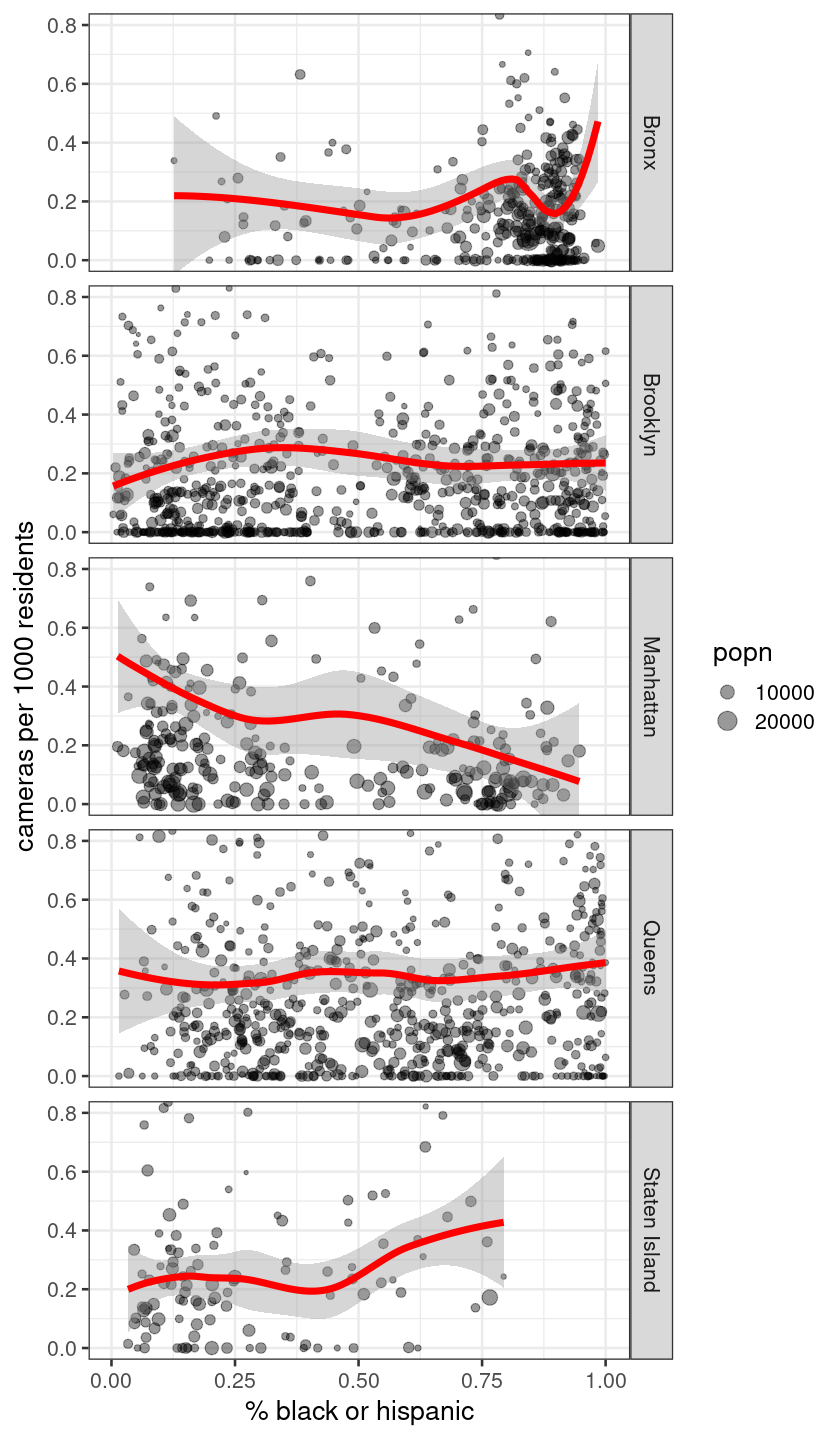

In [21]:
# Does the raw data support the link between nonwhite_fraction and higher surveillance?
# In Manhattan, it's abundantly obvious.
# In other boroughs, possibly yes, but it's a small signal and so it's not surprising
# we need formal statistics to pull it out.

options(repr.plot.width=7, repr.plot.height=12)

ggplot(data=df[popn>250], aes(x=(popn.black + popn.hispanic) / (popn.black + popn.hispanic + popn.white), y=surv)) + 
  geom_point(aes(size=popn), alpha=.4) +
  geom_smooth(method='loess', col='red', size=2, formula=y~x) +
  facet_grid(borough~.) +
  scale_size_area() +
  coord_cartesian(ylim=c(0,.8)) +
  theme_bw(base_size=16) +
  xlab('% black or hispanic') + ylab('cameras per 1000 residents')

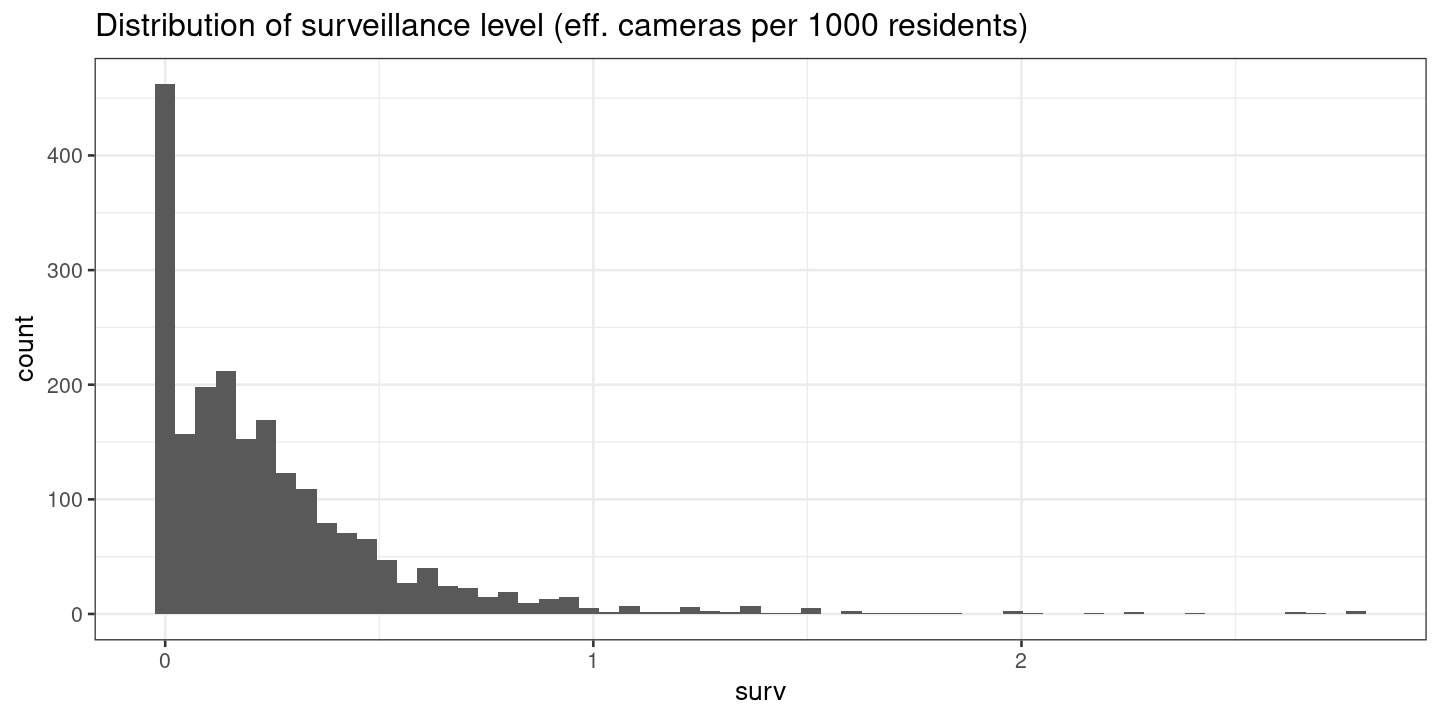

In [22]:
# The distribution of `surv` is definitely non-Gaussian!
# It has a spike at surv=0, then something like a Gamma distribution, then some outliers.
# It's not sound to fit a linear regression.
# That's why I've binarized surv, and fitted a logistic regression.

options(repr.plot.width=12, repr.plot.height=6)
ggplot(data=df[popn>250 & surv<3]) + geom_histogram(aes(x=surv), bins=60) +
  ggtitle('Distribution of surveillance level (eff. cameras per 1000 residents)')

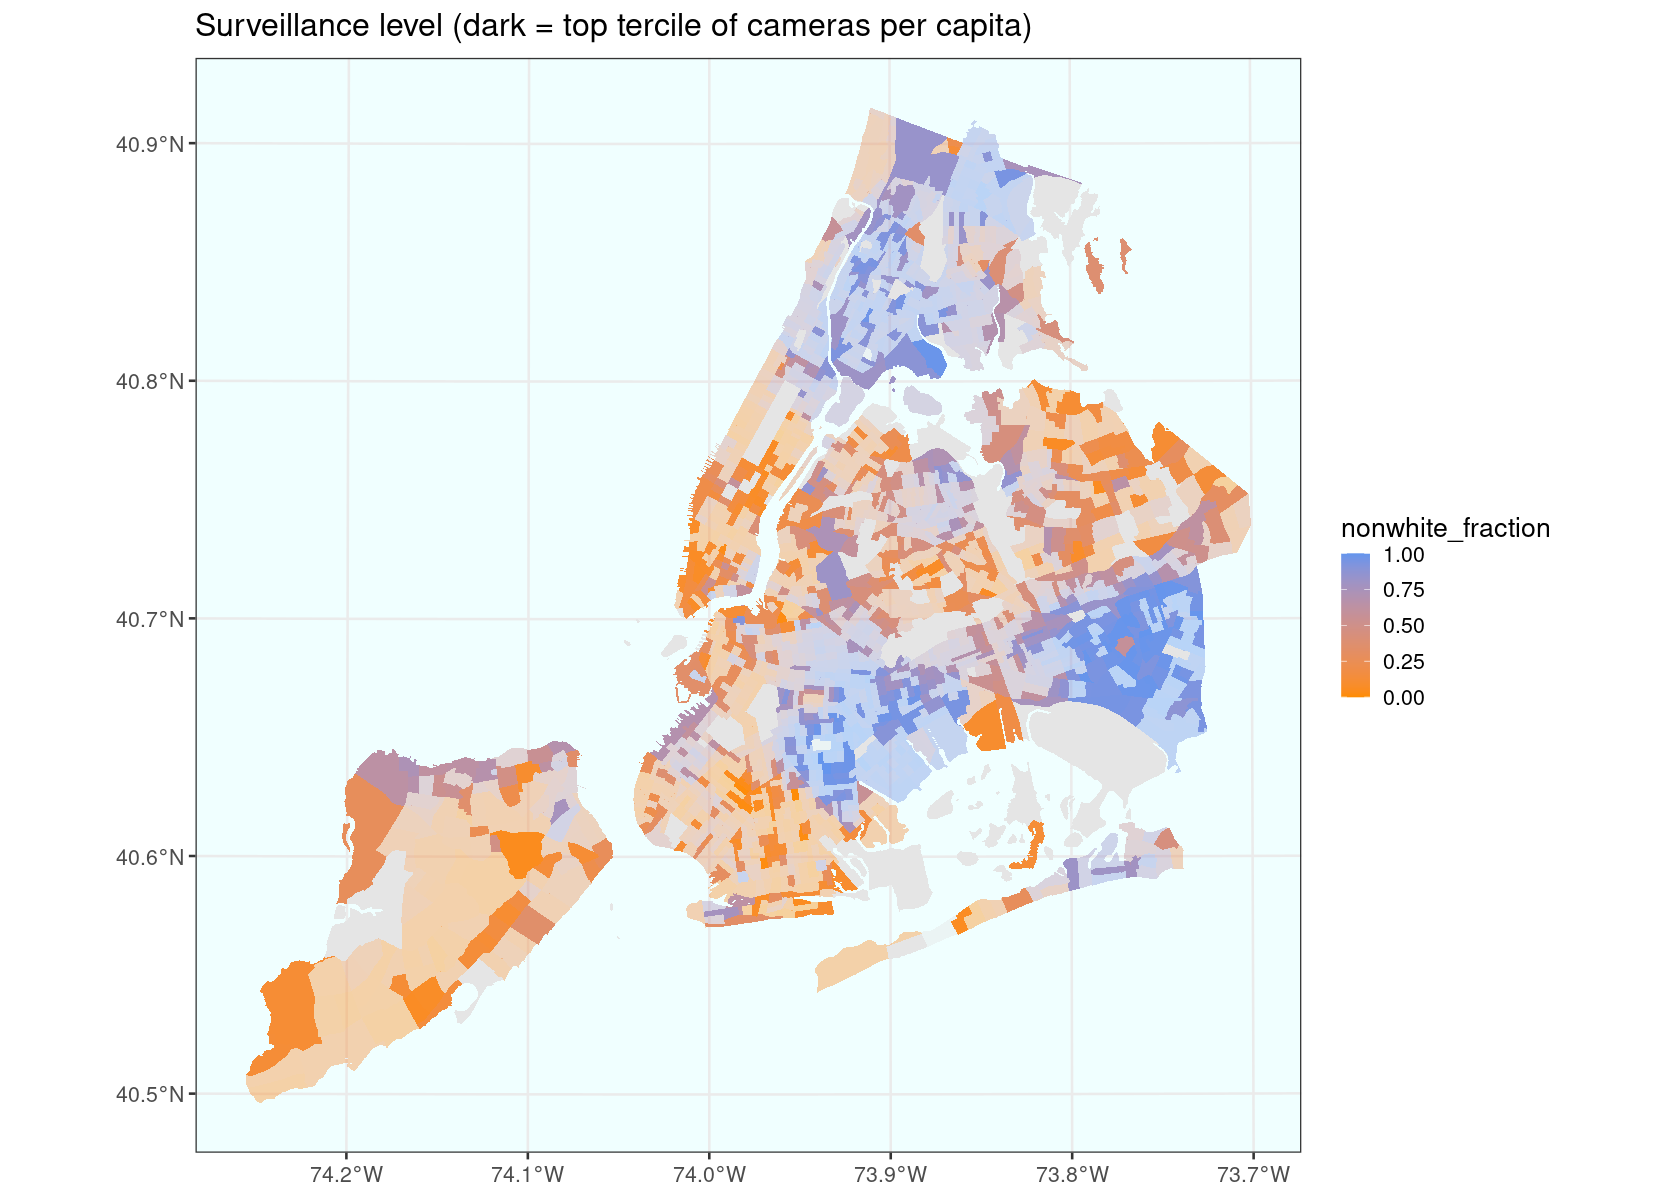

In [23]:
# Map showing relationship between ethnic mix and surveillance.
# Which census tracts have a high level of surveillance?
# This is shown superimposed on nonwhite_fraction.

dft <- merge(tracts[,'GEOID'], df, by='GEOID')

options(repr.plot.width=14, repr.plot.height=10)

ggplot() +
  geom_sf(data=dft, aes(fill=ifelse(popn>250,nonwhite_fraction,NA), alpha=survF), size=0) +
  scale_fill_gradient(limits=c(0,1), low='darkorange', high='cornflowerblue', na.value='grey90',
                     guide=guide_colorbar(title='nonwhite_fraction')) +
  scale_alpha_manual(values=c('high'=1, 'low'=0.4), guide="none") +
  ggtitle('Surveillance level (dark = top tercile of cameras per capita)') +
  theme_bw(base_size=16) +
  theme(panel.background = element_rect(fill='azure'))

## 4. How else do stop-and-frisk actions depend on surveillance?

We have seen that the stop+frisk rate depends on surveillance level: the higher the surveillance level, the higher the rate.
We now investigate this link in 
more granular detail.


**Suspected crime description.** Does the correlation between stop+frisk rate and surveillance level depend on the suspected crime description? Yes it does: there are some suspected crimes, especially ASSAULT, CPW, ROBBERY, LARCENY, where the stop+frisk rate is highly correlated with surveillance level (making up 71% of incidents). For other suspected crimes, there is no correlation.


**Chance of being found innocent.** Might it be that in areas with high surveillance, the police do more uncalled-for stop+frisks, and hence there are more innocent people stopped? No. There is no correlation between the chance of being found innocent and the surveillance level.

**"Stopped while Black."** We'd expect that the stop+frisk rate should depend on the racial mix: in areas with a higher proportion of Black residents, a higher proportion of stop+frisk incidents are likely to be of Black people. Does this ratio vary according to surveillance level? No, not significantly. (The whopping great fact is that there are many more Black people stopped than other races. This is a
property of the stop-and-frisk dataset, and it doesn't seem to be linked to camera surveillance, so it's outside the scope
of this study of surveillance.)

### 4.1 Suspected crime description

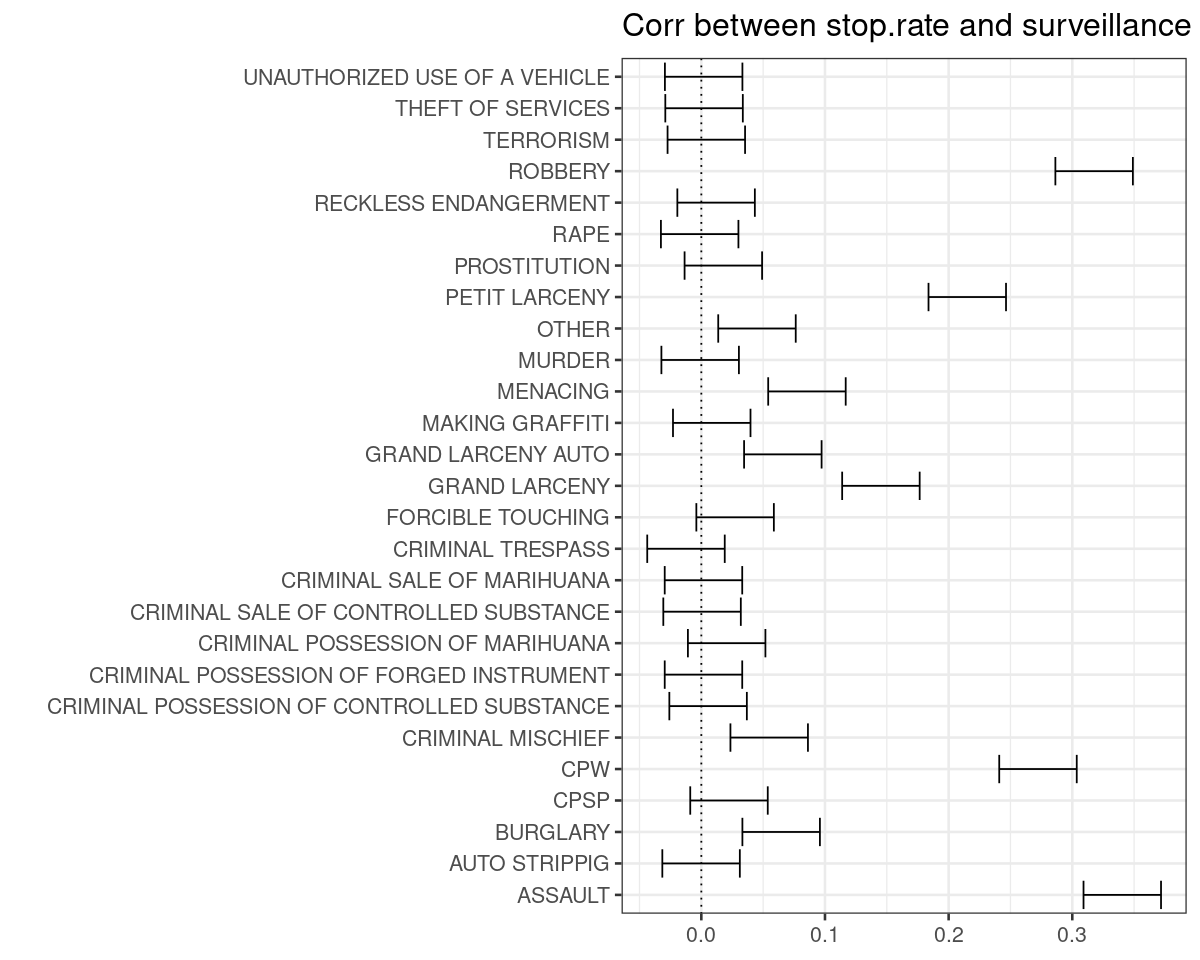

In [24]:
# Analyse the correlation between num. stops (per capita) and num. cameras (per capita), across census tracts
# Use 2019 stop-and-frisk data

df <- as.data.table(expand.grid(SUSPECTED_CRIME_DESCRIPTION=unique(sqf$SUSPECTED_CRIME_DESCRIPTION),
                                GEOID=unique(tracts$GEOID)))
df <- merge(df, as.data.table(sqf)[YEAR2==2019, list(numstops=.N), by=list(GEOID,SUSPECTED_CRIME_DESCRIPTION)],
           by=c('GEOID','SUSPECTED_CRIME_DESCRIPTION'), all=TRUE)
df <- merge(df, census[, list(GEOID, popn)], by='GEOID', all=TRUE)
df <- merge(df, camera_count, by='GEOID', all=TRUE)
df <- merge(df, as.data.table(st_drop_geometry(tracts))[, list(GEOID,borough)], by='GEOID', all=TRUE)
df[is.na(numstops), numstops := 0] # for the tracts with no recorded stops

# Surveillance level has some off-the-scale values.
# A quick fix is to truncate. Another is to regress against rank (survC).
# Both give similar results here.
df[, surv := pmin(eff_cameras / popn * 1000, 3)]
#df[, survC := rank(surv) / .N]
fit <- lmList(numstops/popn*1000 ~ 1 + surv | SUSPECTED_CRIME_DESCRIPTION,
              data=df, subset=popn>250)

x <- summary(fit)
x <- as.data.frame(coef(x)[,,2])
x$SUSPECTED_CRIME_DESCRIPTION <- row.names(x)

options(repr.plot.width=10, repr.plot.height=8)

ggplot(data=x) +
  geom_vline(xintercept=0, linetype='dotted') +
  geom_errorbarh(aes(xmin=Estimate-1.96*`Std. Error`, xmax=Estimate+1.96*`Std. Error`, y=SUSPECTED_CRIME_DESCRIPTION)) +
  theme_bw(base_size=16) +
  ggtitle('Corr between stop.rate and surveillance (2019)') + ylab('')

In [25]:
# What fraction of stops (in 2019) are for the five high-correlation reasons?

x <- as.data.table(sqf)[YEAR2==2019, list(numstops=.N), by=list(SUSPECTED_CRIME_DESCRIPTION)]
x[, corr := SUSPECTED_CRIME_DESCRIPTION %in% c('CPW','ASSAULT','ROBBERY','PETIT LARCENY','GRAND LARCENY')]
x[, list(numstops=sum(numstops)), by=corr][corr==TRUE,numstops] / sum(x$numstops)

[1] 0.7082993

### 4.2 Chance of being found innocent

In [26]:
# Simple tabulation of #stops, #innocent, per SUSPECT_RACE_DESCRIPTION

df <- as.data.table(st_drop_geometry(sqf))
df <- merge(df, camera_count, by='GEOID', all.x=TRUE)
df <- merge(df, census, by='GEOID', all.x=TRUE)

df[, innocent := SUSPECT_ARRESTED_FLAG=='N' & SUMMONS_ISSUED_FLAG=='N' & WEAPON_FOUND_FLAG=='N']
df[, surv := pmin(eff_cameras / popn * 1000, 3)]

df[, bwh := as.character(NA)]
df[SUSPECT_RACE_DESCRIPTION=='BLACK', bwh := 'BLACK']
df[SUSPECT_RACE_DESCRIPTION=='WHITE', bwh := 'WHITE']
df[SUSPECT_RACE_DESCRIPTION %in% c('BLACK HISPANIC', 'WHITE HISPANIC'), bwh := 'HISPANIC']

df[YEAR2==2019, list(n=.N, nInnocent=sum(innocent), percentInnocent=sum(innocent)/.N*100), by=list(SUSPECT_RACE_DESCRIPTION)][order(-n)]

SUSPECT_RACE_DESCRIPTION  n    nInnocent percentInnocent
1 BLACK                     7981 5131      64.29019       
2 WHITE HISPANIC            2742 1728      63.01969       
3 WHITE                     1215  755      62.13992       
4 BLACK HISPANIC            1127  693      61.49068       
5 ASIAN / PACIFIC ISLANDER   301  214      71.09635       
6 (null)                      85   59      69.41176       
7 AMERICAN INDIAN/ALASKAN N    8    5      62.50000

In [27]:
# Does your chance of being found innocent relate to surveillance?

fit <- glm(innocent ~ 0 + bwh + bwh:surv,
           data = df,
           subset = popn>250 & !is.na(bwh) & YEAR2==2019)
summary(fit)


Call:
glm(formula = innocent ~ 0 + bwh + bwh:surv, data = df, subset = popn > 
    250 & !is.na(bwh) & YEAR2 == 2019)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.6788  -0.6293   0.3544   0.3662   0.4304  

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
bwhBLACK          0.646634   0.006973  92.736   <2e-16 ***
bwhHISPANIC       0.631055   0.009780  64.524   <2e-16 ***
bwhWHITE          0.609913   0.017577  34.700   <2e-16 ***
bwhBLACK:surv    -0.009917   0.015486  -0.640    0.522    
bwhHISPANIC:surv -0.020469   0.022521  -0.909    0.363    
bwhWHITE:surv     0.022974   0.034137   0.673    0.501    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 0.2314808)

    Null deviance: 8177.0  on 12857  degrees of freedom
Residual deviance: 2974.8  on 12851  degrees of freedom
AIC: 17681

Number of Fisher Scoring iterations: 2


In [28]:
# How about if we restrict attention to suspected_crimes with a known link to surveillance?

fit2 <- update(fit, subset = popn>250 & !is.na(bwh) & YEAR2==2019 & SUSPECTED_CRIME_DESCRIPTION %in% c('ASSAULT','ROBBERY'))
summary(fit2)


Call:
glm(formula = innocent ~ 0 + bwh + bwh:surv, data = df, subset = popn > 
    250 & !is.na(bwh) & YEAR2 == 2019 & SUSPECTED_CRIME_DESCRIPTION %in% 
    c("ASSAULT", "ROBBERY"))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.7014  -0.5940   0.3580   0.3838   0.5902  

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
bwhBLACK          0.64603    0.01279  50.499   <2e-16 ***
bwhHISPANIC       0.59724    0.01856  32.176   <2e-16 ***
bwhWHITE          0.51712    0.04018  12.870   <2e-16 ***
bwhBLACK:surv    -0.05235    0.02681  -1.952    0.051 .  
bwhHISPANIC:surv -0.06248    0.04191  -1.491    0.136    
bwhWHITE:surv     0.11626    0.07280   1.597    0.110    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 0.2367801)

    Null deviance: 2252.00  on 3685  degrees of freedom
Residual deviance:  871.11  on 3679  degrees of freedom
AIC: 5156.9

Number of Fisher Scorin

### 4.3 "Stopped while Black"

In [29]:
# We'd expect that #stops.black / #stops ~ popn.black / popn.
# Is this relationship impacted by surveillance level?
# No.
# (Whether or not I exclude Manhattan, which is a special case.)
# (I'm using a binarized version of surveillance level, to make it easier
# to interpret the surveillance:popn.black interaction term.)

df <- as.data.table(st_drop_geometry(sqf))
df <- df[YEAR2==2019, list(numstops=.N, numstops.black = sum(SUSPECT_RACE_DESCRIPTION=='BLACK')), by=GEOID]
df <- merge(df, census, by='GEOID', all=TRUE)
df <- merge(df, camera_count, by='GEOID', all=TRUE)
df <- merge(df, as.data.table(st_drop_geometry(tracts))[, list(GEOID, borough)], by='GEOID', all=TRUE)
df[, surv := eff_cameras / popn * 1000]

fit <- lm(numstops.black/numstops ~ 1 + I(popn.black/popn)*I(surv>SURV_THRESHOLD),
         data = df,
         subset = popn>250 & borough != 'Manhattan')
summary(fit)


Call:
lm(formula = numstops.black/numstops ~ 1 + I(popn.black/popn) * 
    I(surv > SURV_THRESHOLD), data = df, subset = popn > 250 & 
    borough != "Manhattan")

Residuals:
     Min       1Q   Median       3Q      Max 
-0.97535 -0.29650 -0.00389  0.17134  0.70482 

Coefficients:
                                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                                      0.29518    0.01482  19.913   <2e-16 ***
I(popn.black/popn)                               0.76378    0.03564  21.433   <2e-16 ***
I(surv > SURV_THRESHOLD)TRUE                     0.01589    0.02159   0.736    0.462    
I(popn.black/popn):I(surv > SURV_THRESHOLD)TRUE -0.01331    0.05049  -0.264    0.792    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3027 on 1512 degrees of freedom
  (311 observations deleted due to missingness)
Multiple R-squared:  0.3739,	Adjusted R-squared:  0.3727 
F-statistic:   301 on 3 and 1512 DF,  p